#### We would run a set of models to establish a base line of accuracy

In [112]:
import pandas as panda
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,label_binarize

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,\
    RepeatedStratifiedKFold,learning_curve

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, \
        classification_report,confusion_matrix,average_precision_score
from sklearn.linear_model import Perceptron, LogisticRegression,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plot
from itertools import cycle
import numpy as np 
from scipy import interp
import seaborn as sns
import itertools, time, datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from numpy import bincount, linspace, mean, std, arange, squeeze

import warnings

warnings.simplefilter('ignore')
%matplotlib inline

In [8]:
np.random.seed(123)

In [9]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

In [11]:
## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
# _x_train, _y_train = smt.fit_sample(_x_train, _y_train)

# smote = SMOTE(ratio='minority')
# x_train, y_train = smote.fit_sample(_x_train,_y_train)

# tl = TomekLinks(return_indices=True, ratio='majority')
# _x_train, _y_train, id_tl = tl.fit_sample(_x_train, _y_train)



In [81]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))





def calculate_roc_and_prec_metrics(y, y_probabilities, number_of_classes):
    
    false_positive_rate_across_class    = dict()
    true_positive_rate_across_class     = dict()
    recall_across_class                 = dict()
    precision_across_class              = dict()
    roc_auc_across_class                = dict()
    average_precision_across_class      = dict()


    for i in range(number_of_classes):

        false_positive_rate_across_class[i], \
                true_positive_rate_across_class[i], _ = roc_curve(y[:, i], y_probabilities[:, i])

        precision_across_class[i], recall_across_class[i], _ = precision_recall_curve(y[:, i],
                                                        y_probabilities[:, i])

        average_precision_across_class[i] = average_precision_score(y[:, i], y_probabilities[:, i])

        roc_auc_across_class[i] = auc(false_positive_rate_across_class[i], true_positive_rate_across_class[i])

        # Compute micro-average ROC curve and ROC area

        false_positive_rate_across_class["micro"], \
                true_positive_rate_across_class["micro"], _ = roc_curve(y.ravel(), y_probabilities.ravel())

        roc_auc_across_class["micro"] = auc(false_positive_rate_across_class["micro"], \
                            true_positive_rate_across_class["micro"])


        precision_across_class["micro"], recall_across_class["micro"], _ = \
                    precision_recall_curve(y.ravel(), y_probabilities.ravel())

        average_precision_across_class["micro"] = average_precision_score(y, y_probabilities,
                                                            average="micro")

    response  = dict() 
    response['false_positive_rate_across_class']    = false_positive_rate_across_class
    response['true_positive_rate_across_class']     = true_positive_rate_across_class
    response['recall_across_class']                 = recall_across_class
    response['precision_across_class']              = precision_across_class
    response['roc_auc_across_class']                = roc_auc_across_class
    response['average_precision_across_class']      = average_precision_across_class

    return response


def plot_roc_auc_curve(false_positive_rate_across_class, \
            true_positive_rate_across_class, roc_auc_across_class, n_classes):
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([false_positive_rate_across_class[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += interp(all_fpr, false_positive_rate_across_class[i], true_positive_rate_across_class[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    false_positive_rate_across_class["macro"] = all_fpr
    true_positive_rate_across_class["macro"] = mean_tpr
    roc_auc_across_class["macro"] = auc(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"])

    # Plot all ROC curves
    plot.figure(figsize = (15,5))
    plot.plot(false_positive_rate_across_class["micro"], true_positive_rate_across_class["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plot.plot(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plot.plot(false_positive_rate_across_class[i], true_positive_rate_across_class[i], color=color, lw=4,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc_across_class[i]))

    plot.plot([0, 1], [0, 1], 'k--', lw=4)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.title('Some extension of Receiver operating characteristic to multi-class')
    plot.legend(loc="lower right")
    plot.show()




def plot_precision_recall_curve(recall_across_class, \
            precision_across_class, average_precision_across_class, n_classes):

    line_width = 4
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plot.figure(figsize=(15, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plot.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plot.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plot.plot(recall_across_class["micro"], precision_across_class["micro"], color='gold', lw=line_width)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision_across_class["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plot.plot(recall_across_class[i], precision_across_class[i], color=color, lw=line_width)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision_across_class[i]))

    fig = plot.gcf()
    fig.subplots_adjust(bottom=0.25)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.title('Extension of Precision-Recall curve to multi-class')
#     plot.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
    plot.legend(lines, labels, loc='best', prop=dict(size=14))
    plot.show()

    

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
    
    
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)

    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
#         _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(range(_y_test.shape[1])))
        _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(set(_y_test)))
        classes = list(set(_y_test))
        plot_confusion_matrix(_matrix, classes)
        
    with predict_proba_timer:

        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            print('inside decision function')
            y_probability = gridsearch.predict_proba(x_test)
            number_of_classes = len(np.unique(y_train))
            y_test_bin = label_binarize(y_test, classes = np.unique(y_train))
            response = calculate_roc_and_prec_metrics(y_test_bin, y_probability, number_of_classes = number_of_classes)

            roc_params = {

                'false_positive_rate_across_class': response.get('false_positive_rate_across_class'),
                'true_positive_rate_across_class': response.get('true_positive_rate_across_class'),
                'roc_auc_across_class': response.get('roc_auc_across_class'),
                'n_classes': number_of_classes
            }

            precision_recall_params  = {

                'precision_across_class': response.get('precision_across_class'),
                'average_precision_across_class': response.get('average_precision_across_class'),
                'recall_across_class': response.get('recall_across_class'),
                'n_classes': number_of_classes
            }

            plot_roc_auc_curve(**roc_params)
            plot_precision_recall_curve(**precision_recall_params)
            response['roc_auc_micro'] = response.get('roc_auc_across_class',{}).get("micro")
            response['roc_auc_macro'] = response.get('roc_auc_across_class',{}).get("macro")
            
            
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_micro'] = 0
            response['roc_auc_macro'] = 0
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['f1_score_micro']  = f1_score(y_test, y_prediction, average ='micro')
    response['f1_score_macro']  = f1_score(y_test, y_prediction, average ='macro')
    response['best_estimator'] = search.best_estimator_
    response['confusion_matrix'] = _matrix
    
    return response


In [13]:
# y = label_binarize(y,classes = np.unique(y))



# _y_train.shape, _y_test.shape

## over sampling majorities first 

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
# _x_train, _y_train = smt.fit_sample(_x_train, _y_train)

In [75]:

## we will add more classifiers in round2
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
    RidgeClassifier(random_state = 123), 
    SVC(kernel='rbf',class_weight='balanced',probability=True)
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge',
            'svc'
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {'logisticregression__C':[100,300, 500]},
            {'decisiontreeclassifier__max_depth':[6,8,10],'decisiontreeclassifier__criterion':['gini','entropy']},
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini',]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
            {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]},
            {'svc__C':[1,1.2,0.5], 'svc__max_iter':[100,200]}
    
]


In [76]:

def execute( _x_train,
             _y_train,
             _x_test,
             _y_test, 
            classifiers, 
            classifier_names, 
            classifier_param_grid,
            cv  = 10 , 
            score = 'accuracy',
            scaler = StandardScaler()
           ):
    
    '''
    This method will run your data sets against the model specified 
    Models will be fed through a pipeline where the first step would be to
    execute a scaling operation.
    
    Method will also call additional lower level methods in order to plot
    precision curve, roc curve, learning curve and will also prepare a confusion matrix
    
    :returns: dict containing execution metrics such as time taken, accuracy scores
    :returntype: dict
    
    '''

    timer = CodeTimer(name='overalltime')
    model_metrics = {}

    with timer:
        for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline = Pipeline([
#                     ('scaler', scaler),since we have already done dimensionality reduction, we dont need to rescale
                    (model_name, model)
            ])

            result = runGridSearchAndPredict(pipeline, 
                                             _x_train,
                                             _y_train,
                                             _x_test,
                                             _y_test, 
                                             model_param_grid ,
                                             cv = cv,
                                             score = 'f1_weighted')

            _y_prediction = result['_y_prediction']

#             cf = panda.crosstab(
#                 panda.Series(_y_test, name='Actual'),
#                 panda.Series(_y_prediction, name = 'Prediction'),
#                 margins = True
#             )

#             print(cf)

            model_metrics[model_name] = {}
            model_metrics[model_name]['confusion_matrix'] = result.get('confusion_matrix')
            model_metrics[model_name]['training_time'] = result.get('training_time')
            model_metrics[model_name]['testing_time'] = result.get('testing_time')
            model_metrics[model_name]['learning_curve_time'] = result.get('learning_curve_time')
            model_metrics[model_name]['f1_score'] = result.get('f1_score')
            model_metrics[model_name]['f1_score_macro'] = result.get('f1_score_macro')
            model_metrics[model_name]['f1_score_micro'] = result.get('f1_score_micro')
            model_metrics[model_name]['roc_auc_macro'] = result.get('roc_auc_macro')
            model_metrics[model_name]['roc_auc_micro'] = result.get('roc_auc_micro')

            model_metrics[model_name]['best_estimator'] = result.get('best_estimator')
#             model_metrics[model_name]['cf'] = cf


    print(timer.took)
    
    return model_metrics


In [16]:
train_data = panda.read_csv('data/train_2.csv')
test_data = panda.read_csv('data/test_2.csv')

In [17]:

columns_not_required = ['id','idhogar','target']
x = train_data[[i for i in train_data.columns.tolist() if i not in columns_not_required]]
y = train_data['target']


In [61]:
def plot_variance_scree_plot(variance, cumulative_variance,n_components_ , title = 'Principal Component vs Explained Ratio'):
    with plot.style.context('seaborn-whitegrid'):
        plot.figure(figsize=(10, 5))

        plot.bar(range(1,n_components_ ), variance, alpha=0.8, align='center',
                label='individual explained variance', color = 'teal') ## since there are 13 dimenison
        plot.step(range(1,n_components_ ), cumulative_variance, where='mid',
                 label='cumulative explained variance', color ='red')
        plot.plot(variance, color = 'black', label = 'Scree')
        plot.ylabel('Explained variance ratio')
        plot.xlabel('Principal components')
        plot.legend(loc='best')
        plot.tight_layout()
        plot.title(title)
        plot.show()

In [62]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)


In [63]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(_x_train)
x_test_std = scaler.fit_transform(_x_test)

In [64]:
x_train_std.shape

(2081, 174)

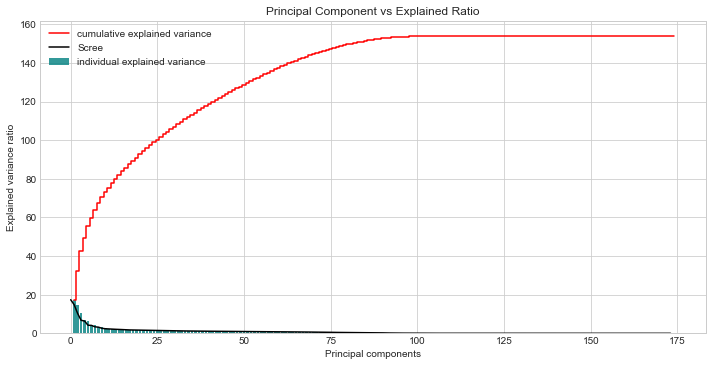

In [65]:


pca = PCA()
x_train_pca1 = pca.fit_transform(x_train_std)

x_test_pca1 = pca.transform(x_test_std)

plot_variance_scree_plot(pca.explained_variance_ ,np.cumsum(pca.explained_variance_),pca.n_components_ +1 )


We see that close to first 15 is where the elbow point remains. Lets transform to PCA again in with n_components as 15

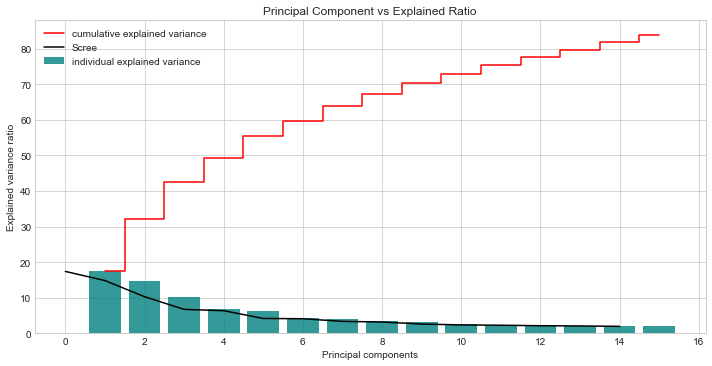

In [69]:
pca = PCA(n_components =15)
pca.fit(x_train_std)
plot_variance_scree_plot(pca.explained_variance_ ,np.cumsum(pca.explained_variance_),pca.n_components_ +1 )


In [79]:
pca = PCA(n_components  = 6)
x_train_std = pca.fit_transform(x_train_std)
x_test_std = pca.transform(x_test_std)

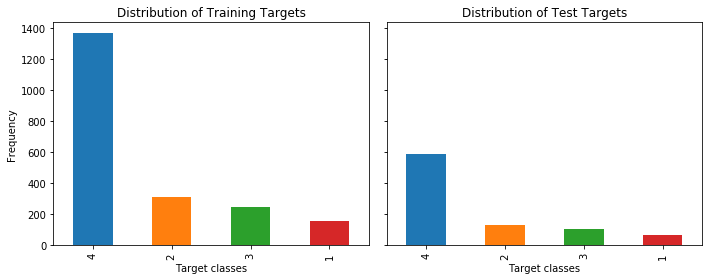

In [71]:


f, (ax1, ax2) = plot.subplots(1, 2, sharey=True, figsize=(10,4))
_y_train.value_counts().plot(kind='bar', label='Distribution of Training targets',ax=ax1)

ax1.set_xlabel('Target classes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Training Targets')

_y_test.value_counts().plot(kind='bar', label='Distribution of Training targets', ax=ax2)

ax2.set_xlabel('Target classes')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Test Targets')
plot.tight_layout()
plot.show()

In [73]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  0.5718532359087765
Code block 'training' took(HH:MM:SS): 0:00:00.136879
Code block 'testing' took(HH:MM:SS): 0:00:00.000319
F1 score 0.5555819929031486
Classification report  
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        67
           2       0.22      0.26      0.24       133
           3       0.16      0.24      0.19       106
           4       0.77      0.75      0.76       586

   micro avg       0.56      0.56      0.56       892
   macro avg       0.29      0.31      0.30       892
weighted avg       0.56      0.56      0.56       892



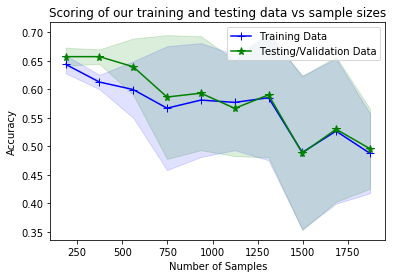

Confusion matrix, without normalization
[[  0  12  24  31]
 [  0  35  44  54]
 [  0  34  25  47]
 [  0  80  68 438]]


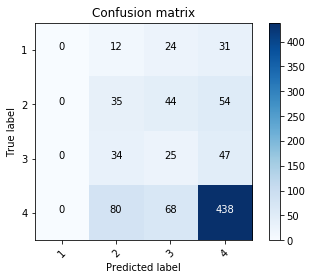

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.836066
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000018
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.5868182399004611
Code block 'training' took(HH:MM:SS): 0:00:00.163581
Code block 'testing' took(HH:MM:SS): 0:00:00.000351
F1 score 0.5803231418518043
Classification report  
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        67
           2       0.32      0.27      0.30       133
           3       0.00      0.00      0.00       106
           4       0.71      0.95      0.82       586

   micro avg       0.67      0.67      0.67       892
   macro avg       0.26      0.31      0.28       892
weighted avg       0.52      0.67      0.58       892



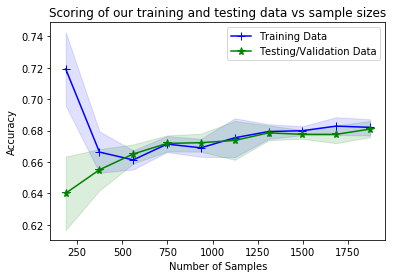

Confusion matrix, without normalization
[[  0  23   0  44]
 [  0  36   0  97]
 [  0  24   0  82]
 [  0  28   0 558]]


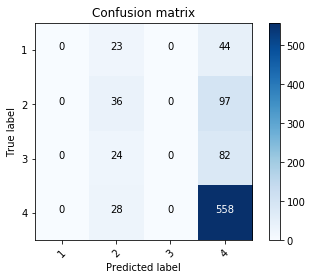

Code block 'learning_curve' took(HH:MM:SS): 0:00:10.842683
inside decision function


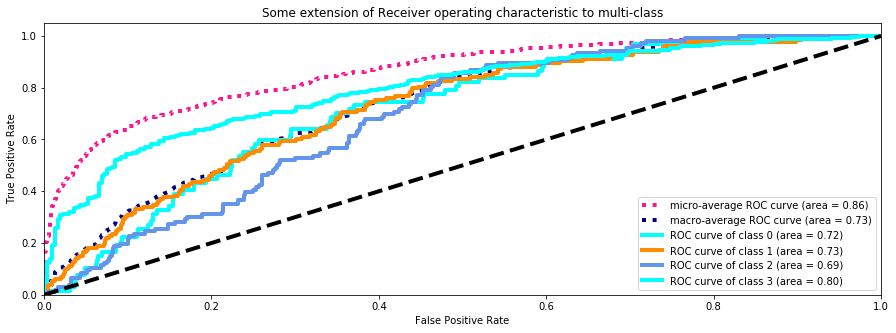

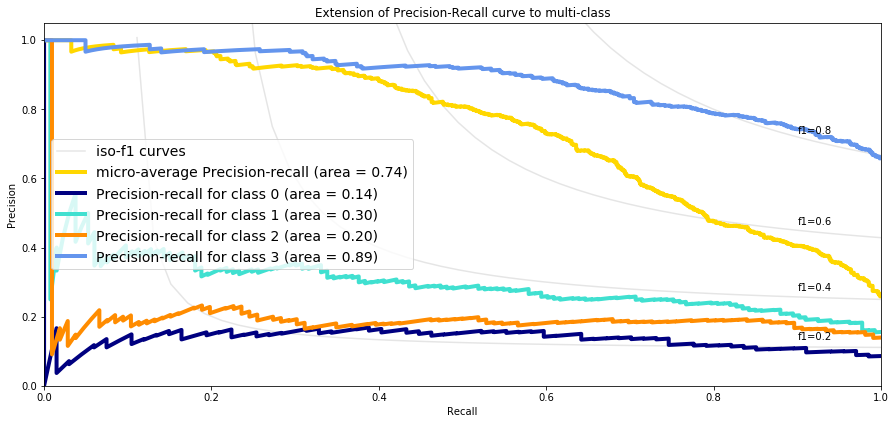

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.440199
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  0.5924052642256367
Code block 'training' took(HH:MM:SS): 0:00:00.398129
Code block 'testing' took(HH:MM:SS): 0:00:00.000320
F1 score 0.5731900402750336
Classification report  
               precision    recall  f1-score   support

           1       0.18      0.09      0.12        67
           2       0.26      0.26      0.26       133
           3       0.13      0.02      0.03       106
           4       0.72      0.88      0.79       586

   micro avg       0.62      0.62      0.62       892
   macro avg       0.32      0.31      0.30       892
weighted avg       0.54      0.62      0.57       892



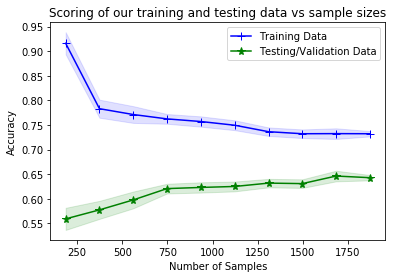

Confusion matrix, without normalization
[[  6  23   2  36]
 [  6  35   4  88]
 [  7  25   2  72]
 [ 15  50   7 514]]


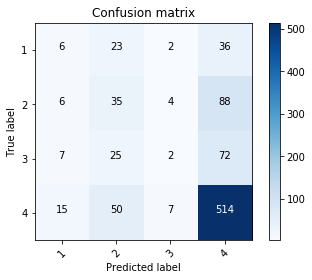

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.006636
inside decision function


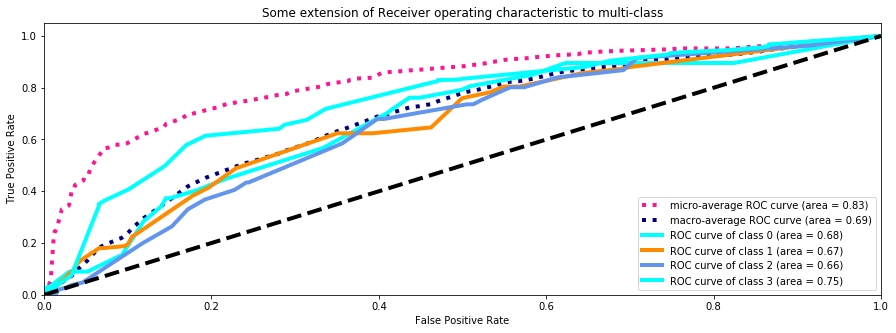

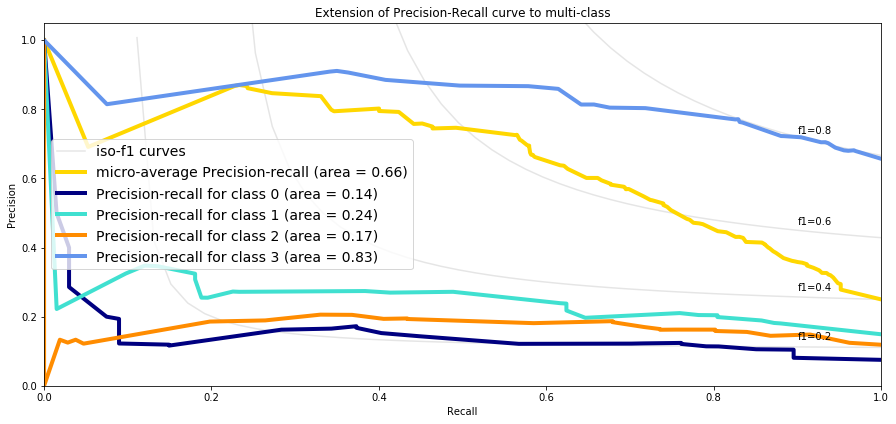

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.378370
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6022331729861601
Code block 'training' took(HH:MM:SS): 0:00:00.482960
Code block 'testing' took(HH:MM:SS): 0:00:00.003716
F1 score 0.5747693689010659
Classification report  
               precision    recall  f1-score   support

           1       0.06      0.04      0.05        67
           2       0.28      0.28      0.28       133
           3       0.15      0.08      0.10       106
           4       0.74      0.84      0.79       586

   micro avg       0.60      0.60      0.60       892
   macro avg       0.31      0.31      0.30       892
weighted avg       0.55      0.60      0.57       892



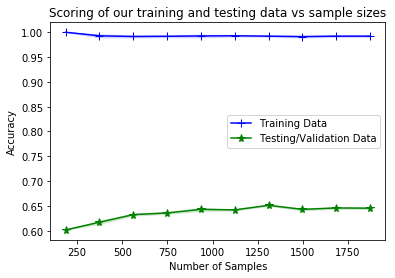

Confusion matrix, without normalization
[[  3  25  10  29]
 [ 10  37  12  74]
 [ 11  22   8  65]
 [ 23  50  23 490]]


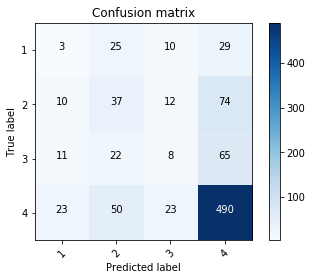

Code block 'learning_curve' took(HH:MM:SS): 0:00:03.589748
inside decision function


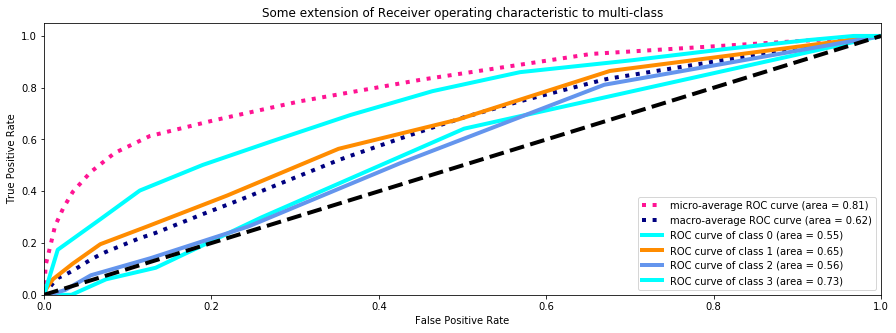

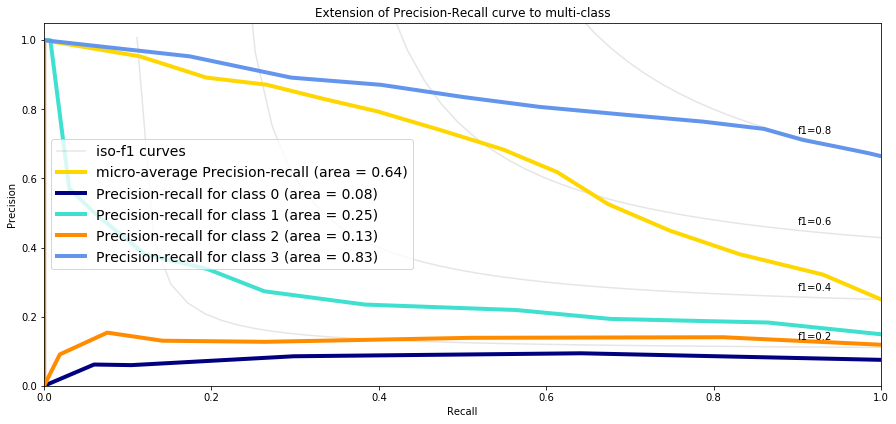

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.381637
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.5950250978136444
Code block 'training' took(HH:MM:SS): 0:00:00.316582
Code block 'testing' took(HH:MM:SS): 0:00:00.011893
F1 score 0.5715484495795293
Classification report  
               precision    recall  f1-score   support

           1       0.11      0.06      0.08        67
           2       0.33      0.23      0.27       133
           3       0.14      0.03      0.05       106
           4       0.71      0.89      0.79       586

   micro avg       0.63      0.63      0.63       892
   macro avg       0.32      0.30      0.30       892
weighted avg       0.54      0.63      0.57       892



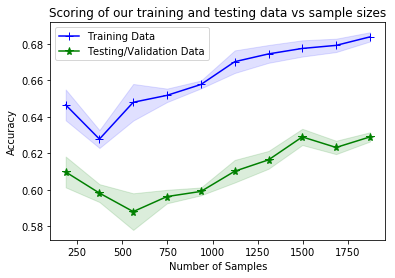

Confusion matrix, without normalization
[[  4  11   2  50]
 [ 11  31   5  86]
 [  6  18   3  79]
 [ 16  35  11 524]]


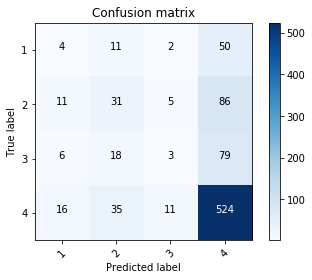

Code block 'learning_curve' took(HH:MM:SS): 0:00:10.393034
inside decision function


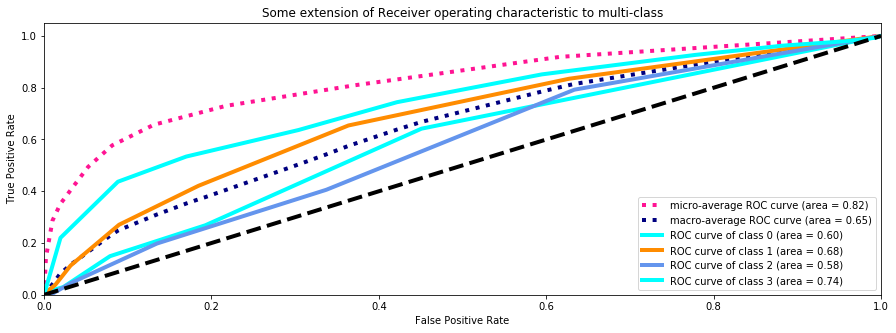

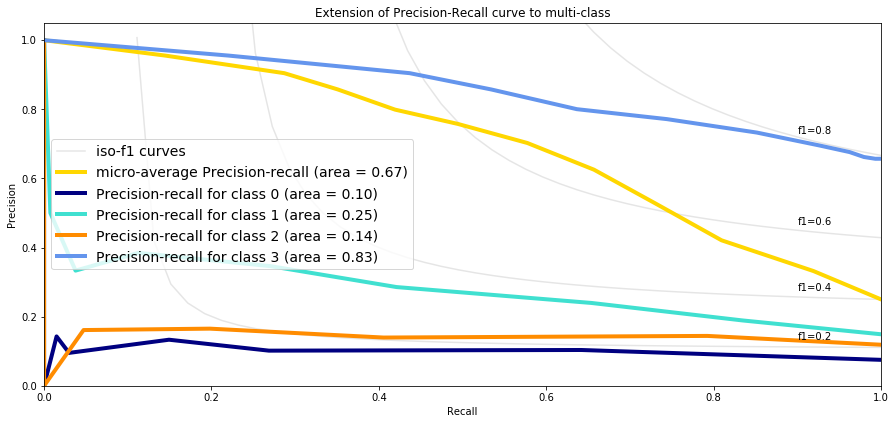

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.407397
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.565146955549749
Code block 'training' took(HH:MM:SS): 0:00:00.190265
Code block 'testing' took(HH:MM:SS): 0:00:00.000497
F1 score 0.5695538622126463
Classification report  
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        67
           2       0.35      0.18      0.24       133
           3       0.00      0.00      0.00       106
           4       0.70      0.98      0.81       586

   micro avg       0.67      0.67      0.67       892
   macro avg       0.26      0.29      0.26       892
weighted avg       0.51      0.67      0.57       892



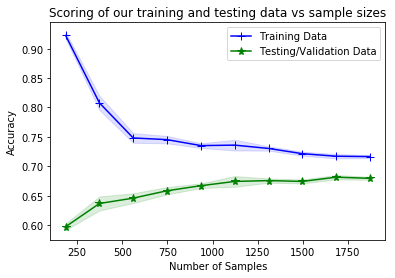

Confusion matrix, without normalization
[[  0  17   0  50]
 [  0  24   0 109]
 [  0  14   0  92]
 [  0  13   0 573]]


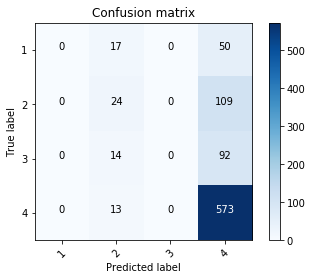

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.329453
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000016
Grid Search Best parameters  {'svc__C': 1.2, 'svc__max_iter': 200}
Grid Search Best score  0.07082327508026616
Code block 'training' took(HH:MM:SS): 0:00:06.013016
Code block 'testing' took(HH:MM:SS): 0:00:00.019275
F1 score 0.06491809518451488
Classification report  
               precision    recall  f1-score   support

           1       0.05      0.13      0.07        67
           2       0.19      0.50      0.28       133
           3       0.10      0.34      0.15       106
           4       0.00      0.00      0.00       586

   micro avg       0.12      0.12      0.12       892
   macro avg       0.09      0.24      0.13       892
weighted avg       0.04      0.12      0.06       892



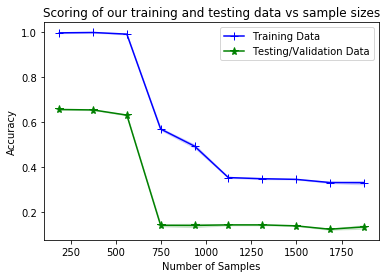

Confusion matrix, without normalization
[[  9  33  25   0]
 [ 28  66  39   0]
 [ 25  45  36   0]
 [117 197 272   0]]


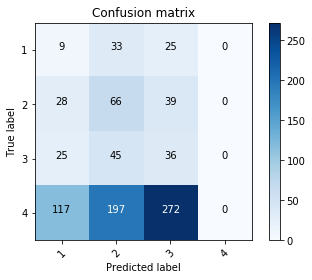

Code block 'learning_curve' took(HH:MM:SS): 0:02:56.909182
inside decision function


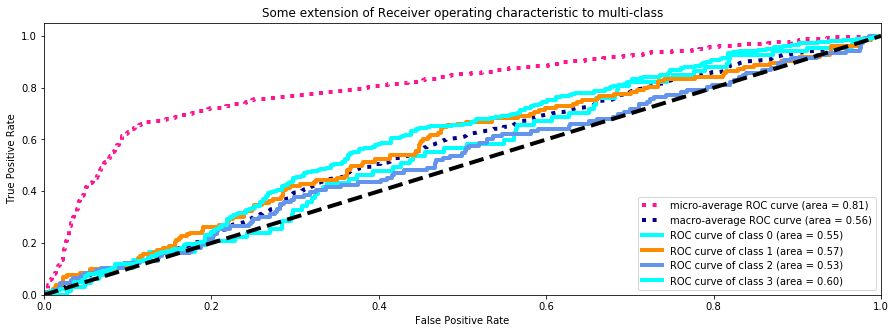

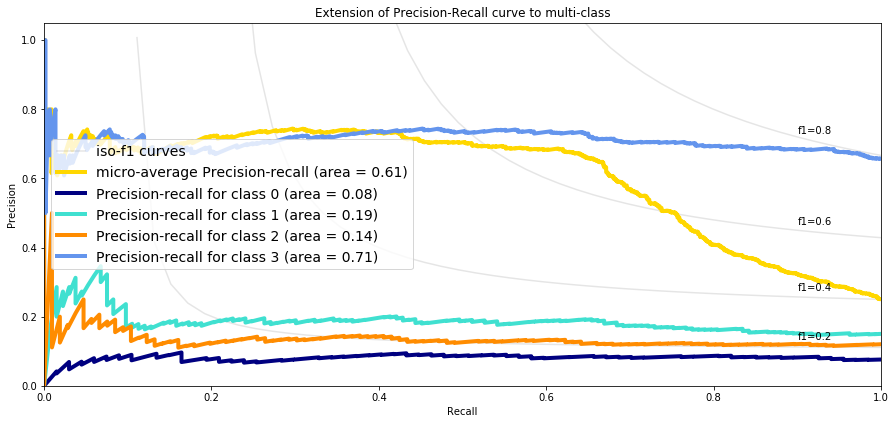

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.412142
Code block 'overalltime' took(HH:MM:SS): 0:03:36.715712
216715.71208086403


In [82]:
response = execute(x_train_std,
        _y_train,
        x_test_std,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [83]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.569554,0.262893,0.669283,1329.45,0,0,0.497209,190.265
logisticregression,0.580323,0.277867,0.665919,10842.7,0.733591,0.860781,0.351004,163.581
kneighborsclassifier,0.571548,0.29676,0.630045,10393,0.649072,0.823229,11.8932,316.582
decisiontreeclassifier,0.57319,0.302059,0.624439,2006.64,0.688398,0.825869,0.319715,398.129
randomforestclassifier,0.574769,0.304549,0.603139,3589.75,0.62375,0.807586,3.71598,482.96
perceptron,0.555582,0.295787,0.558296,1836.07,0,0,0.318578,136.879
svc,0.0649181,0.12557,0.124439,176909,0.562589,0.807869,19.2751,6013.02


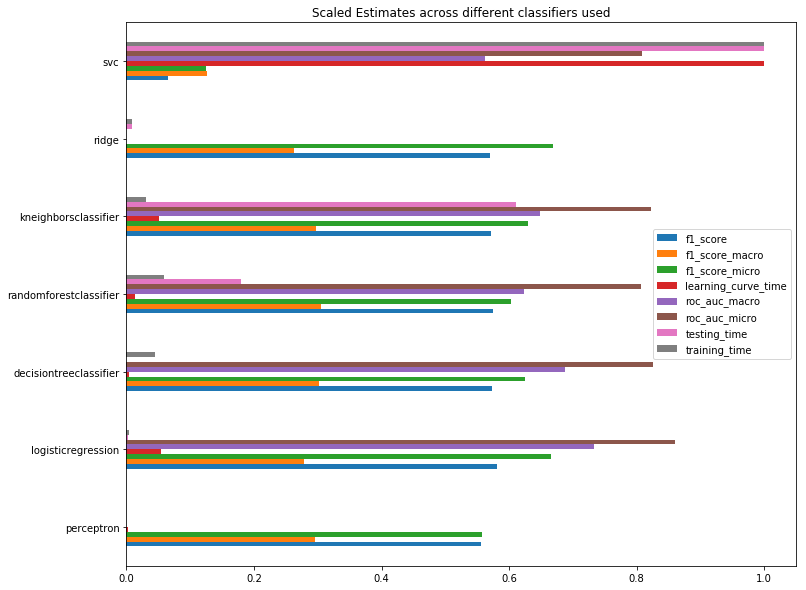

In [84]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion on dimensionality reduction : very less amount of variance has been defined and results in worse f1 scores

<br><br><br>

##### Lets try LDA and t-SNE techniques

In [99]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)


scaler = StandardScaler()
x_train_std = scaler.fit_transform(_x_train)
x_test_std = scaler.fit_transform(_x_test)

In [106]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_std, _y_train)
x_train_lda = lda.transform(x_train_std)
x_test_lda = lda.transform(x_test_std)


In [107]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  0.6274278907450741
Code block 'training' took(HH:MM:SS): 0:00:00.110971
Code block 'testing' took(HH:MM:SS): 0:00:00.000324
F1 score 0.5852015402031782
Classification report  
               precision    recall  f1-score   support

           1       0.33      0.01      0.03        67
           2       0.24      0.39      0.30       133
           3       0.22      0.36      0.27       106
           4       0.83      0.72      0.77       586

   micro avg       0.57      0.57      0.57       892
   macro avg       0.41      0.37      0.34       892
weighted avg       0.64      0.57      0.59       892



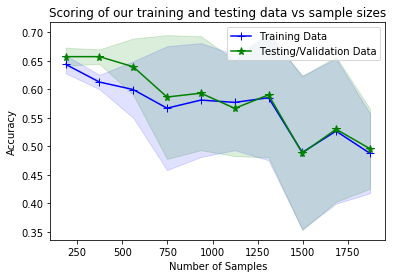

Confusion matrix, without normalization
[[  1  24  26  16]
 [  1  52  48  32]
 [  1  32  38  35]
 [  0 106  61 419]]


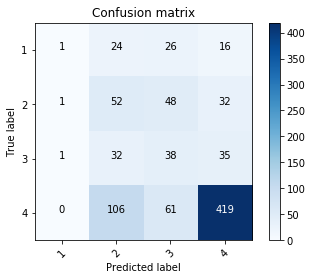

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.888515
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000012
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.6900304234033875
Code block 'training' took(HH:MM:SS): 0:00:00.102853
Code block 'testing' took(HH:MM:SS): 0:00:00.000371
F1 score 0.6067906989979795
Classification report  
               precision    recall  f1-score   support

           1       0.29      0.13      0.18        67
           2       0.34      0.27      0.30       133
           3       0.22      0.09      0.13       106
           4       0.74      0.90      0.81       586

   micro avg       0.65      0.65      0.65       892
   macro avg       0.40      0.35      0.36       892
weighted avg       0.58      0.65      0.61       892



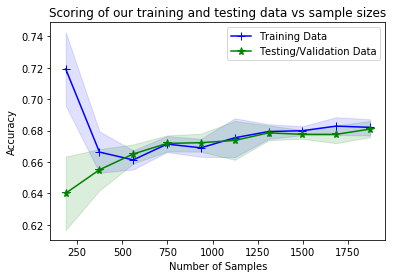

Confusion matrix, without normalization
[[  9  22   2  34]
 [  8  36  11  78]
 [  6  17  10  73]
 [  8  30  23 525]]


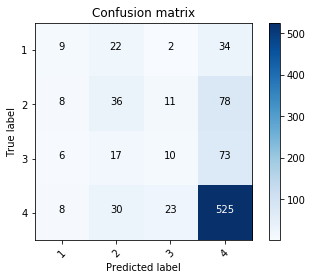

Code block 'learning_curve' took(HH:MM:SS): 0:00:11.268094
inside decision function


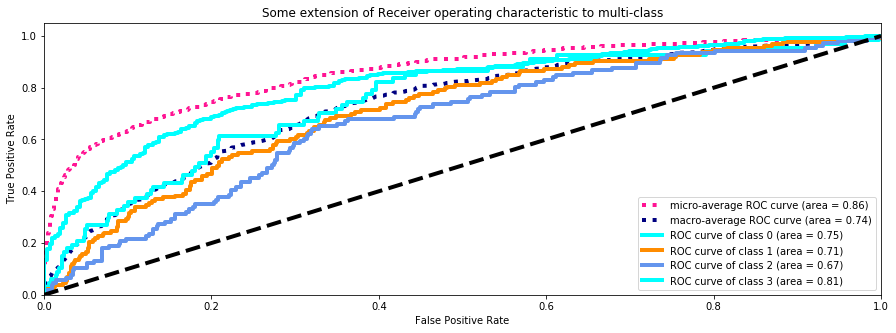

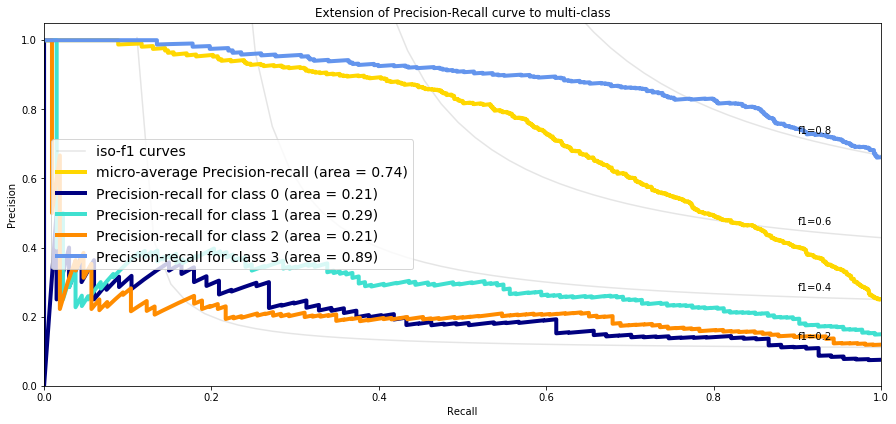

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.403866
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  0.6548989100689042
Code block 'training' took(HH:MM:SS): 0:00:00.240631
Code block 'testing' took(HH:MM:SS): 0:00:00.000375
F1 score 0.6133902708825707
Classification report  
               precision    recall  f1-score   support

           1       0.24      0.15      0.18        67
           2       0.34      0.31      0.32       133
           3       0.22      0.21      0.21       106
           4       0.77      0.83      0.80       586

   micro avg       0.63      0.63      0.63       892
   macro avg       0.39      0.37      0.38       892
weighted avg       0.60      0.63      0.61       892



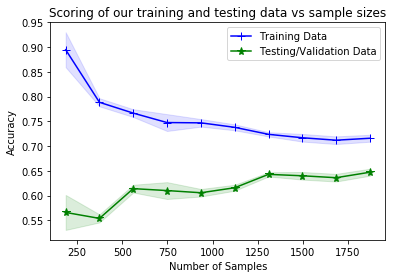

Confusion matrix, without normalization
[[ 10  20   9  28]
 [ 13  41  19  60]
 [  5  23  22  56]
 [ 14  36  49 487]]


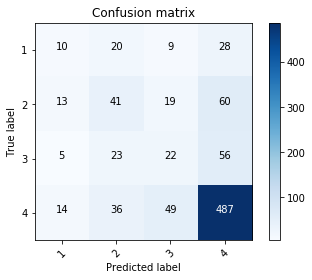

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.443080
inside decision function


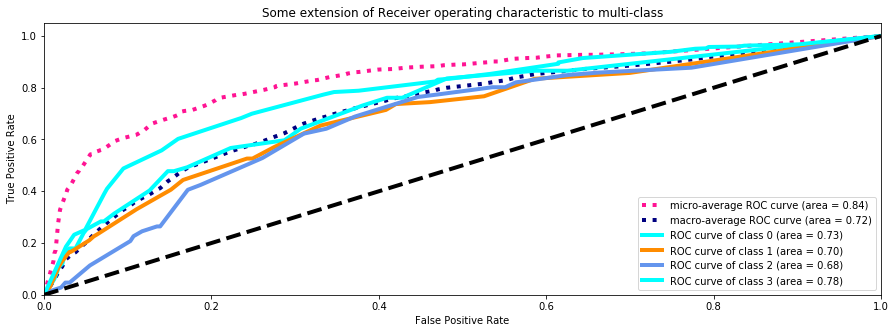

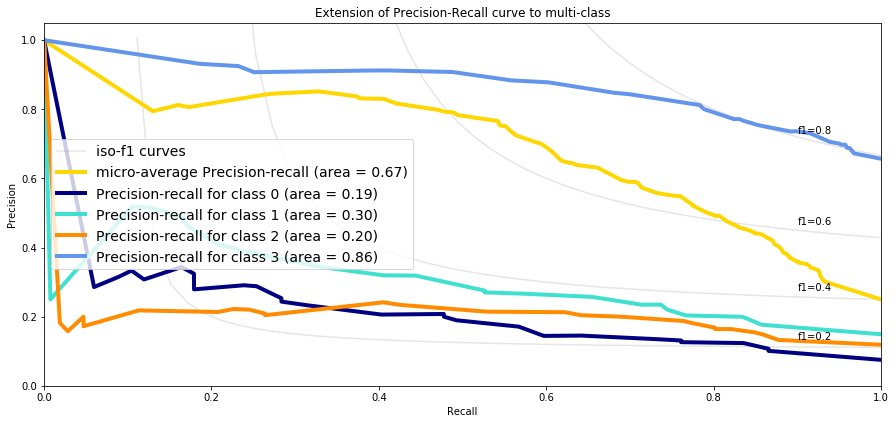

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.411984
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6648652263003161
Code block 'training' took(HH:MM:SS): 0:00:00.369527
Code block 'testing' took(HH:MM:SS): 0:00:00.003734
F1 score 0.6225994139928218
Classification report  
               precision    recall  f1-score   support

           1       0.24      0.18      0.21        67
           2       0.31      0.29      0.30       133
           3       0.25      0.16      0.19       106
           4       0.78      0.86      0.82       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.39      0.37      0.38       892
weighted avg       0.61      0.64      0.62       892



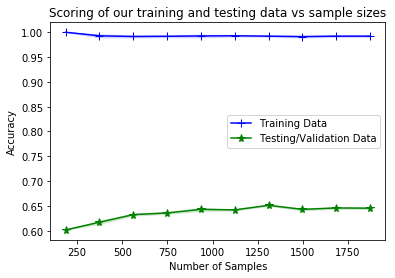

Confusion matrix, without normalization
[[ 12  23   7  25]
 [ 14  39  19  61]
 [  7  27  17  55]
 [ 17  37  26 506]]


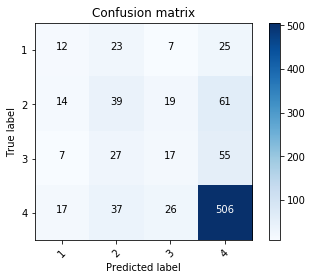

Code block 'learning_curve' took(HH:MM:SS): 0:00:03.734812
inside decision function


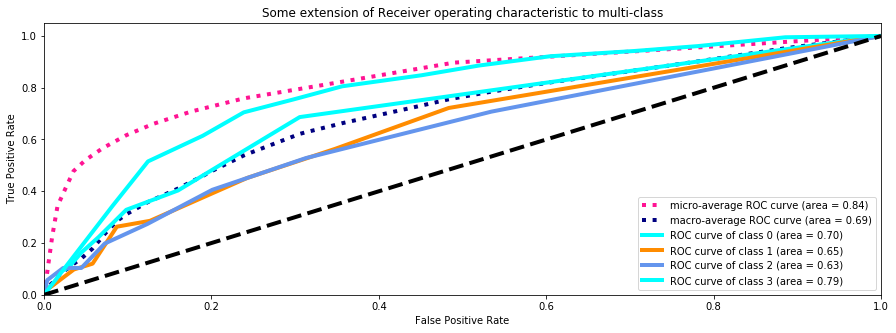

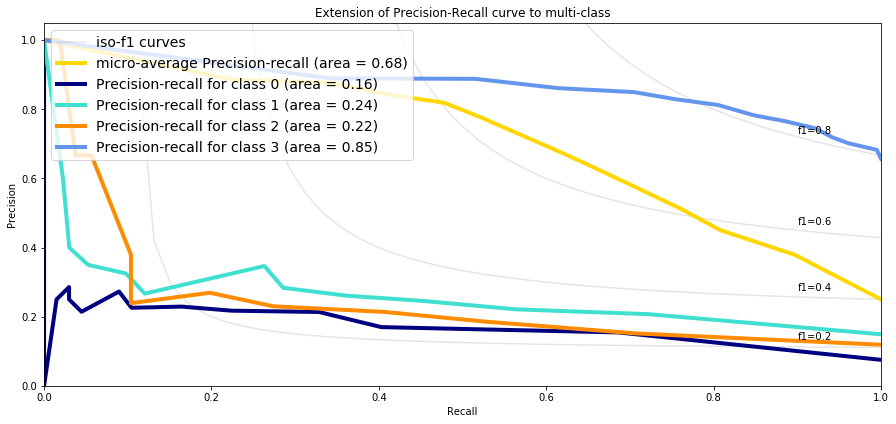

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.425295
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.6920455654026024
Code block 'training' took(HH:MM:SS): 0:00:00.182736
Code block 'testing' took(HH:MM:SS): 0:00:00.005476
F1 score 0.619412863754701
Classification report  
               precision    recall  f1-score   support

           1       0.34      0.27      0.30        67
           2       0.34      0.29      0.31       133
           3       0.22      0.13      0.16       106
           4       0.76      0.86      0.81       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.41      0.39      0.40       892
weighted avg       0.60      0.64      0.62       892



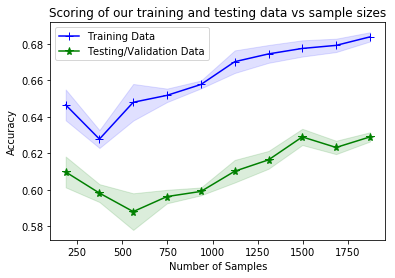

Confusion matrix, without normalization
[[ 18  15   9  25]
 [ 15  39  11  68]
 [  9  19  14  64]
 [ 11  42  30 503]]


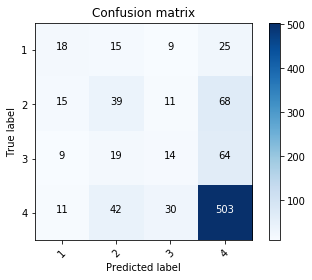

Code block 'learning_curve' took(HH:MM:SS): 0:00:10.969368
inside decision function


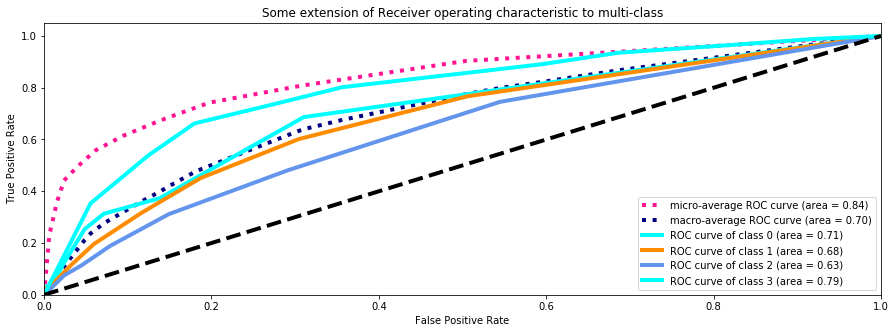

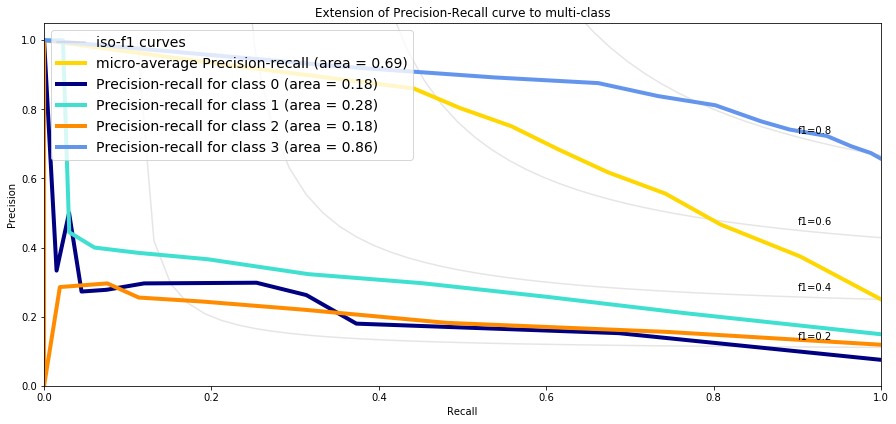

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.397882
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.6566353200383552
Code block 'training' took(HH:MM:SS): 0:00:00.185941
Code block 'testing' took(HH:MM:SS): 0:00:00.000384
F1 score 0.6055660898633115
Classification report  
               precision    recall  f1-score   support

           1       0.29      0.09      0.14        67
           2       0.36      0.27      0.31       133
           3       0.29      0.08      0.12       106
           4       0.73      0.92      0.81       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.41      0.34      0.34       892
weighted avg       0.59      0.66      0.61       892



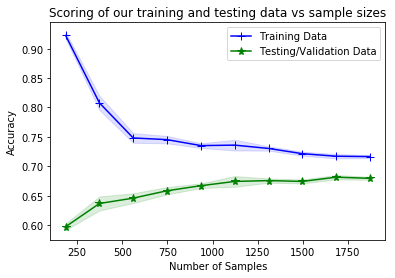

Confusion matrix, without normalization
[[  6  23   0  38]
 [  8  36   7  82]
 [  3  14   8  81]
 [  4  28  13 541]]


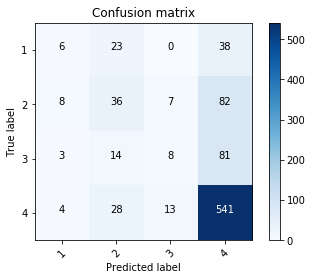

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.586822
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000016
Grid Search Best parameters  {'svc__C': 1.2, 'svc__max_iter': 200}
Grid Search Best score  0.11562999365231905
Code block 'training' took(HH:MM:SS): 0:00:04.873130
Code block 'testing' took(HH:MM:SS): 0:00:00.015673
F1 score 0.06884755175804892
Classification report  
               precision    recall  f1-score   support

           1       0.09      0.40      0.15        67
           2       0.18      0.27      0.21       133
           3       0.14      0.51      0.22       106
           4       0.00      0.00      0.00       586

   micro avg       0.13      0.13      0.13       892
   macro avg       0.10      0.30      0.14       892
weighted avg       0.05      0.13      0.07       892



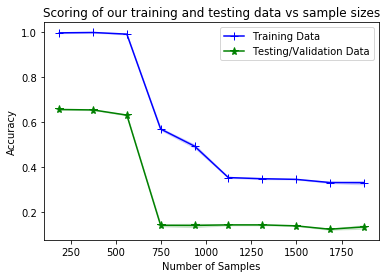

Confusion matrix, without normalization
[[ 27  14  26   0]
 [ 34  36  63   0]
 [ 28  24  54   0]
 [205 128 253   0]]


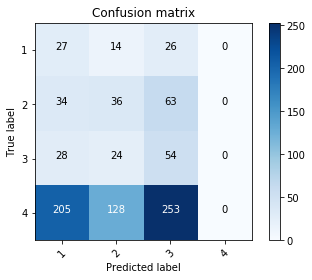

Code block 'learning_curve' took(HH:MM:SS): 0:02:58.540443
inside decision function


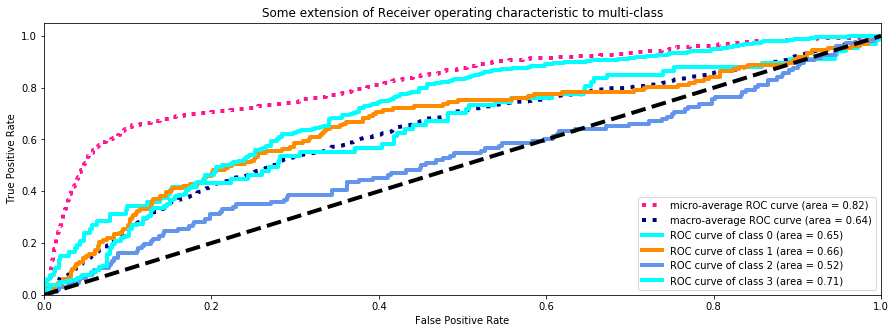

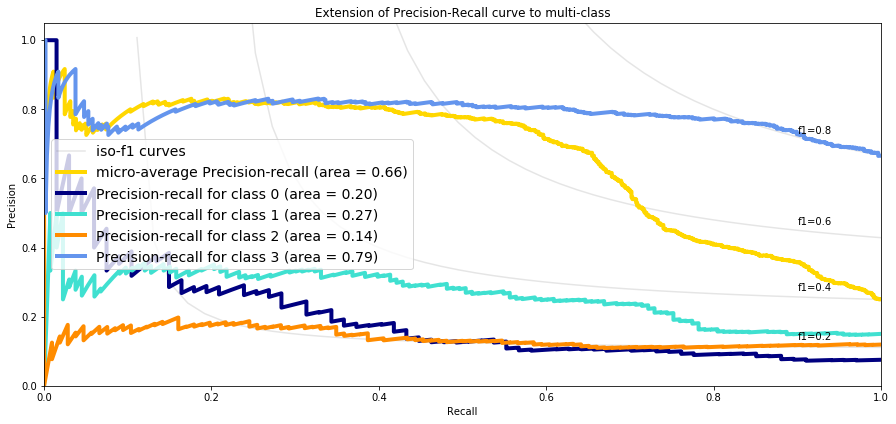

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.411759
Code block 'overalltime' took(HH:MM:SS): 0:03:38.628418
218628.41781236124


In [108]:
response = execute(x_train_lda,
        _y_train,
        x_test_lda,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [109]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.605566,0.344554,0.662556,1586.82,0,0,0.384,185.941
logisticregression,0.606791,0.35699,0.650224,11268.1,0.73682,0.85688,0.370915,102.853
randomforestclassifier,0.622599,0.380334,0.643498,3734.81,0.693378,0.835225,3.73362,369.527
kneighborsclassifier,0.619413,0.396651,0.643498,10969.4,0.704902,0.840619,5.47555,182.736
decisiontreeclassifier,0.61339,0.38064,0.627803,2443.08,0.721795,0.836037,0.375467,240.631
perceptron,0.585202,0.342726,0.571749,1888.52,0,0,0.323698,110.971
svc,0.0688476,0.144912,0.131166,178540,0.63857,0.821353,15.6735,4873.13


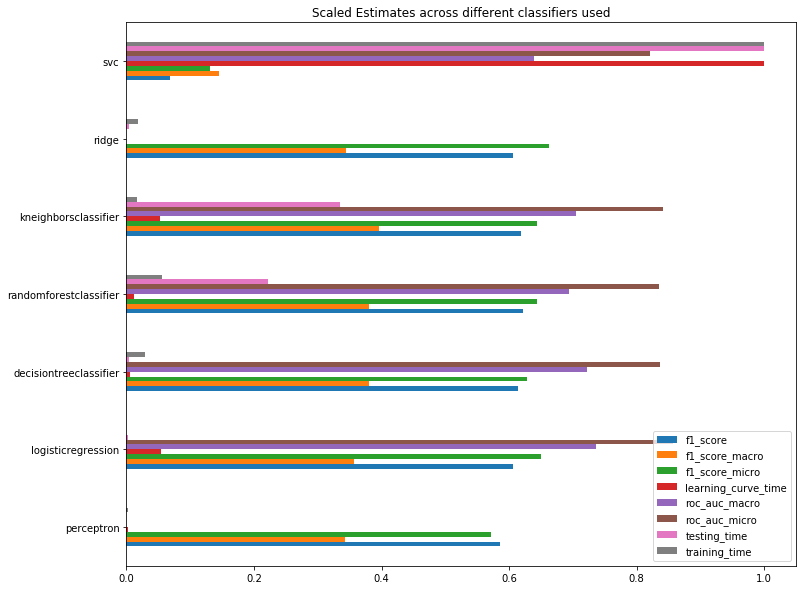

In [111]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion: We do see better f1 macro score for Kneighbor classifier using LDA reduction

#### t-SNE technique

In [113]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)


scaler = StandardScaler()
x_train_std = scaler.fit_transform(_x_train)
x_test_std = scaler.fit_transform(_x_test)

In [114]:
tsne = TSNE()
lda.fit(x_train_std, _y_train)
x_train_lda = lda.transform(x_train_std)
x_test_lda = lda.transform(x_test_std)


In [115]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  0.6274278907450741
Code block 'training' took(HH:MM:SS): 0:00:00.113660
Code block 'testing' took(HH:MM:SS): 0:00:00.000376
F1 score 0.5852015402031782
Classification report  
               precision    recall  f1-score   support

           1       0.33      0.01      0.03        67
           2       0.24      0.39      0.30       133
           3       0.22      0.36      0.27       106
           4       0.83      0.72      0.77       586

   micro avg       0.57      0.57      0.57       892
   macro avg       0.41      0.37      0.34       892
weighted avg       0.64      0.57      0.59       892



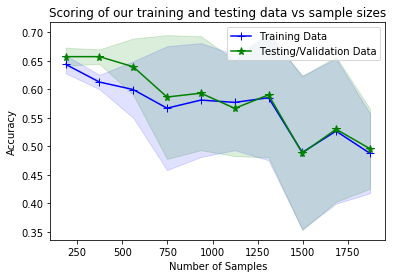

Confusion matrix, without normalization
[[  1  24  26  16]
 [  1  52  48  32]
 [  1  32  38  35]
 [  0 106  61 419]]


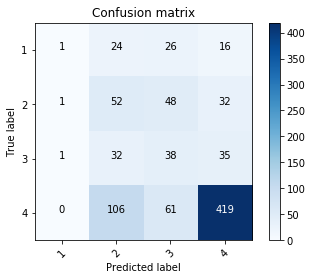

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.821735
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000013
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.6900304234033875
Code block 'training' took(HH:MM:SS): 0:00:00.106126
Code block 'testing' took(HH:MM:SS): 0:00:00.000674
F1 score 0.6067906989979795
Classification report  
               precision    recall  f1-score   support

           1       0.29      0.13      0.18        67
           2       0.34      0.27      0.30       133
           3       0.22      0.09      0.13       106
           4       0.74      0.90      0.81       586

   micro avg       0.65      0.65      0.65       892
   macro avg       0.40      0.35      0.36       892
weighted avg       0.58      0.65      0.61       892



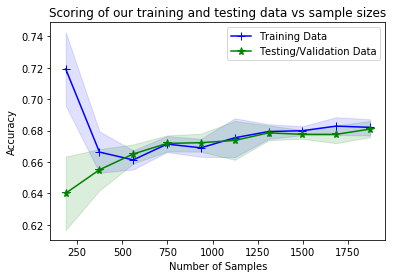

Confusion matrix, without normalization
[[  9  22   2  34]
 [  8  36  11  78]
 [  6  17  10  73]
 [  8  30  23 525]]


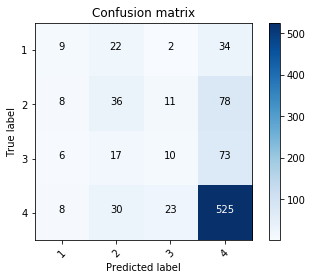

Code block 'learning_curve' took(HH:MM:SS): 0:00:11.474634
inside decision function


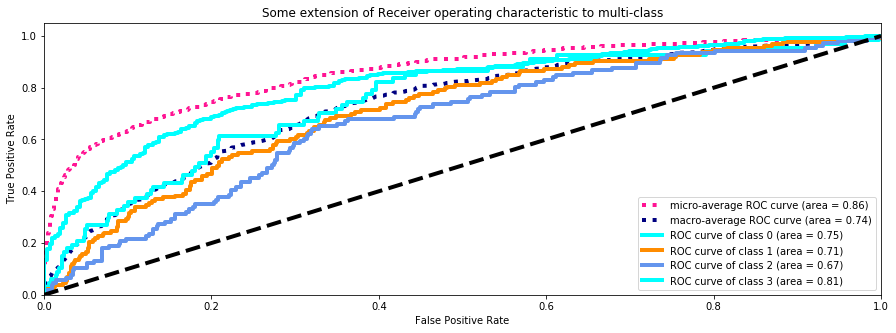

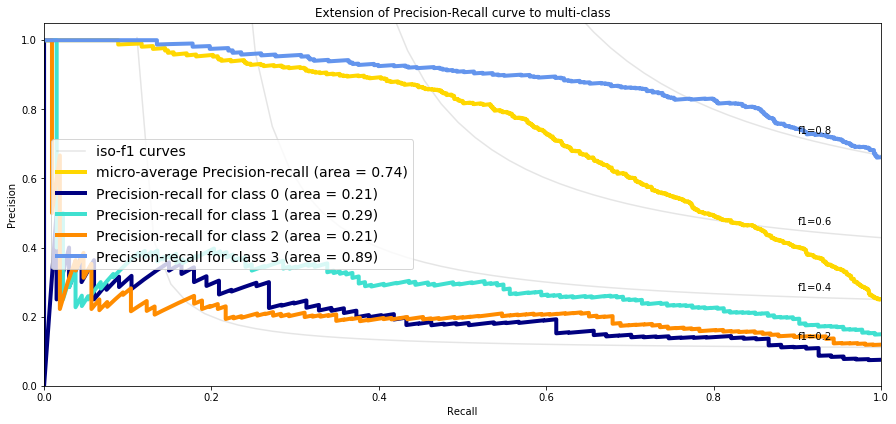

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.469084
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 8}
Grid Search Best score  0.655828217796626
Code block 'training' took(HH:MM:SS): 0:00:00.235053
Code block 'testing' took(HH:MM:SS): 0:00:00.001031
F1 score 0.5958439194608162
Classification report  
               precision    recall  f1-score   support

           1       0.23      0.19      0.21        67
           2       0.28      0.27      0.28       133
           3       0.17      0.13      0.15       106
           4       0.77      0.82      0.79       586

   micro avg       0.61      0.61      0.61       892
   macro avg       0.36      0.35      0.36       892
weighted avg       0.58      0.61      0.60       892



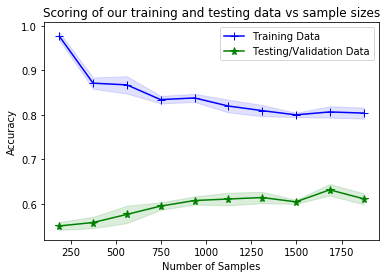

Confusion matrix, without normalization
[[ 13  21   5  28]
 [ 15  36  22  60]
 [  9  25  14  58]
 [ 20  45  40 481]]


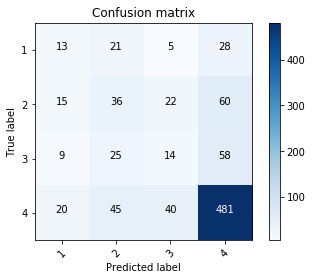

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.439712
inside decision function


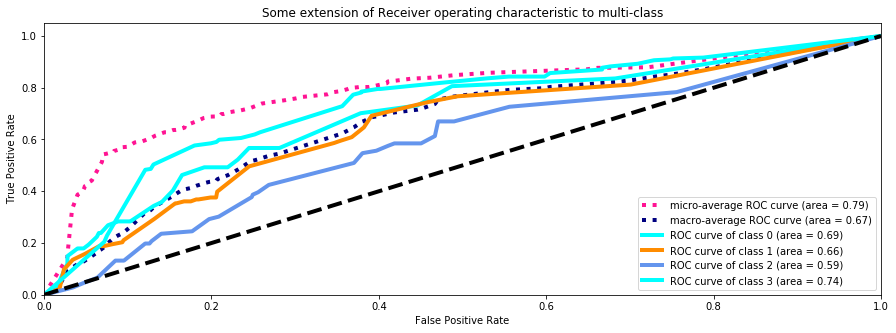

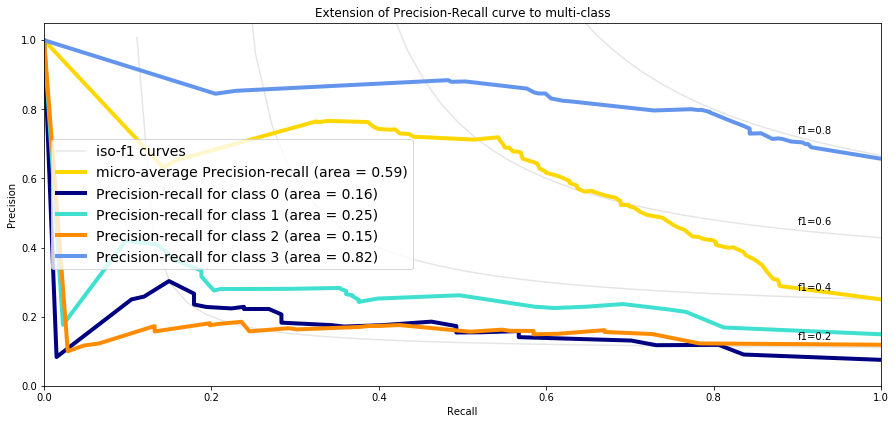

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.368095
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.6648652263003161
Code block 'training' took(HH:MM:SS): 0:00:00.339220
Code block 'testing' took(HH:MM:SS): 0:00:00.003675
F1 score 0.6225994139928218
Classification report  
               precision    recall  f1-score   support

           1       0.24      0.18      0.21        67
           2       0.31      0.29      0.30       133
           3       0.25      0.16      0.19       106
           4       0.78      0.86      0.82       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.39      0.37      0.38       892
weighted avg       0.61      0.64      0.62       892



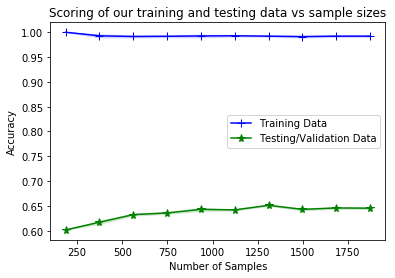

Confusion matrix, without normalization
[[ 12  23   7  25]
 [ 14  39  19  61]
 [  7  27  17  55]
 [ 17  37  26 506]]


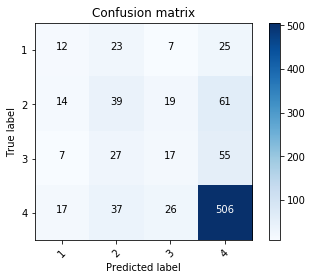

Code block 'learning_curve' took(HH:MM:SS): 0:00:03.572055
inside decision function


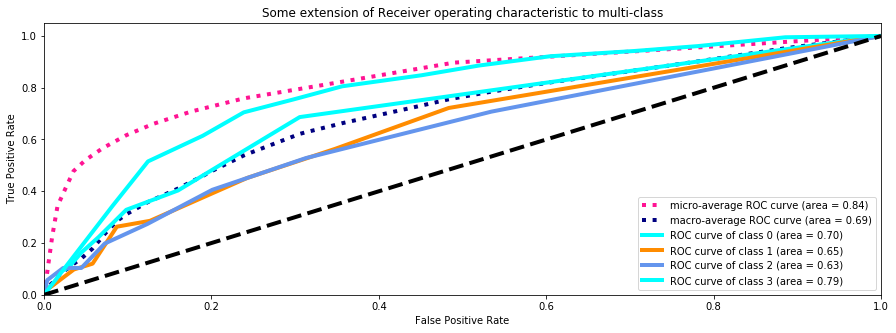

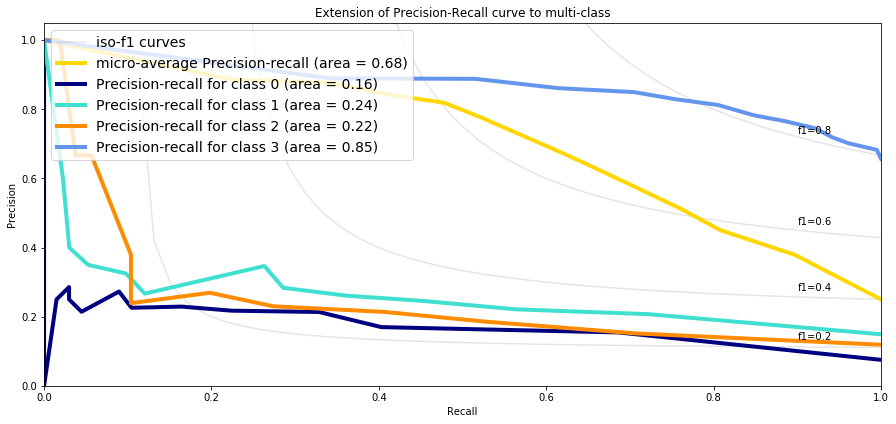

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.367576
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.6920455654026024
Code block 'training' took(HH:MM:SS): 0:00:00.171883
Code block 'testing' took(HH:MM:SS): 0:00:00.004983
F1 score 0.619412863754701
Classification report  
               precision    recall  f1-score   support

           1       0.34      0.27      0.30        67
           2       0.34      0.29      0.31       133
           3       0.22      0.13      0.16       106
           4       0.76      0.86      0.81       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.41      0.39      0.40       892
weighted avg       0.60      0.64      0.62       892



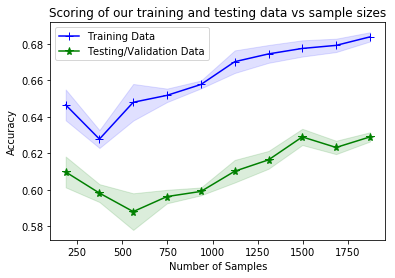

Confusion matrix, without normalization
[[ 18  15   9  25]
 [ 15  39  11  68]
 [  9  19  14  64]
 [ 11  42  30 503]]


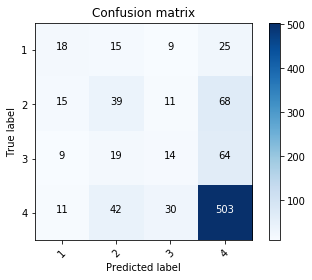

Code block 'learning_curve' took(HH:MM:SS): 0:00:10.489383
inside decision function


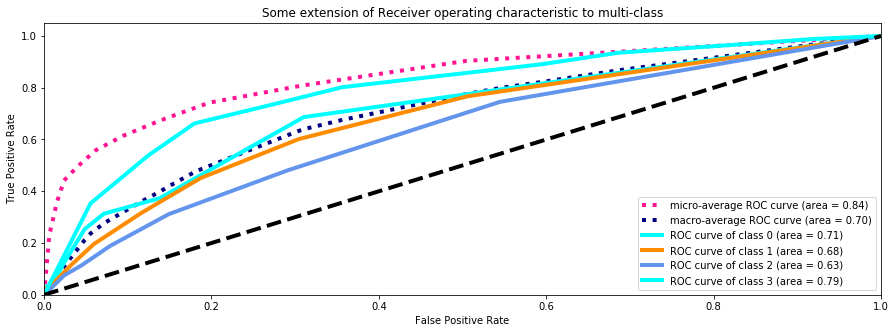

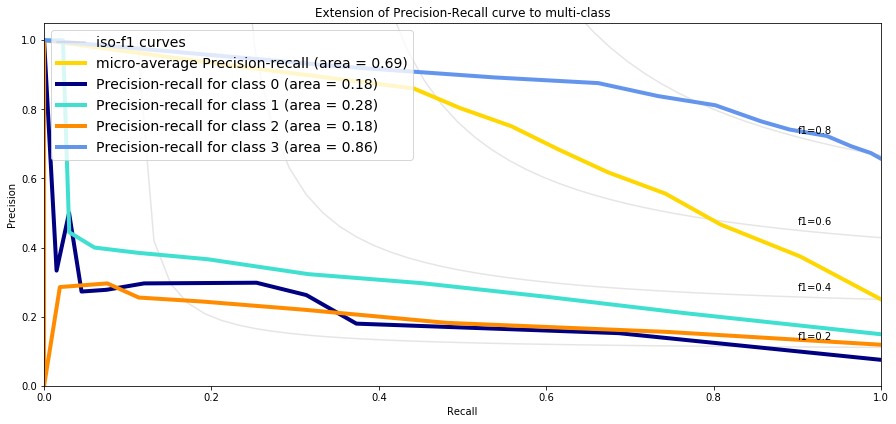

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.416774
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.6566353200383552
Code block 'training' took(HH:MM:SS): 0:00:00.189735
Code block 'testing' took(HH:MM:SS): 0:00:00.000325
F1 score 0.6055660898633115
Classification report  
               precision    recall  f1-score   support

           1       0.29      0.09      0.14        67
           2       0.36      0.27      0.31       133
           3       0.29      0.08      0.12       106
           4       0.73      0.92      0.81       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.41      0.34      0.34       892
weighted avg       0.59      0.66      0.61       892



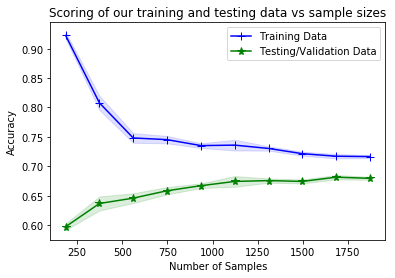

Confusion matrix, without normalization
[[  6  23   0  38]
 [  8  36   7  82]
 [  3  14   8  81]
 [  4  28  13 541]]


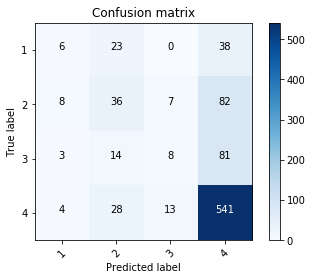

Code block 'learning_curve' took(HH:MM:SS): 0:00:01.343387
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000017
Grid Search Best parameters  {'svc__C': 1.2, 'svc__max_iter': 200}
Grid Search Best score  0.11562999365231905
Code block 'training' took(HH:MM:SS): 0:00:04.900256
Code block 'testing' took(HH:MM:SS): 0:00:00.015605
F1 score 0.06884755175804892
Classification report  
               precision    recall  f1-score   support

           1       0.09      0.40      0.15        67
           2       0.18      0.27      0.21       133
           3       0.14      0.51      0.22       106
           4       0.00      0.00      0.00       586

   micro avg       0.13      0.13      0.13       892
   macro avg       0.10      0.30      0.14       892
weighted avg       0.05      0.13      0.07       892



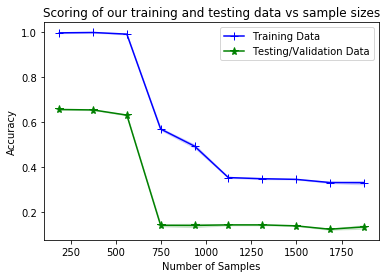

Confusion matrix, without normalization
[[ 27  14  26   0]
 [ 34  36  63   0]
 [ 28  24  54   0]
 [205 128 253   0]]


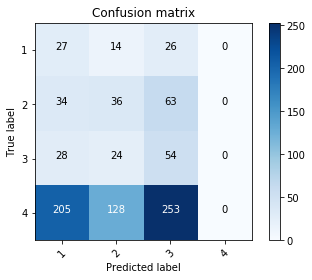

Code block 'learning_curve' took(HH:MM:SS): 0:02:57.142033
inside decision function


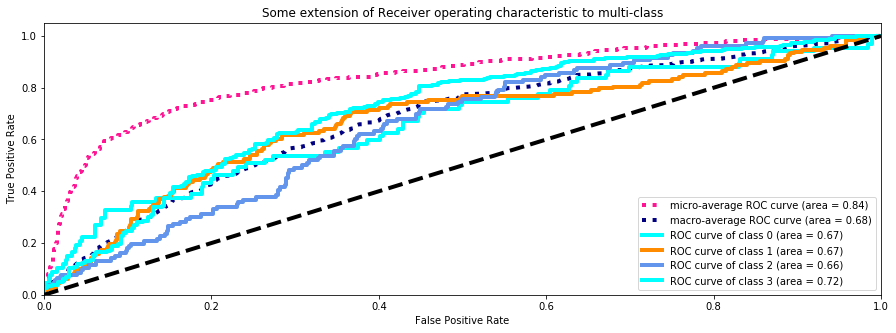

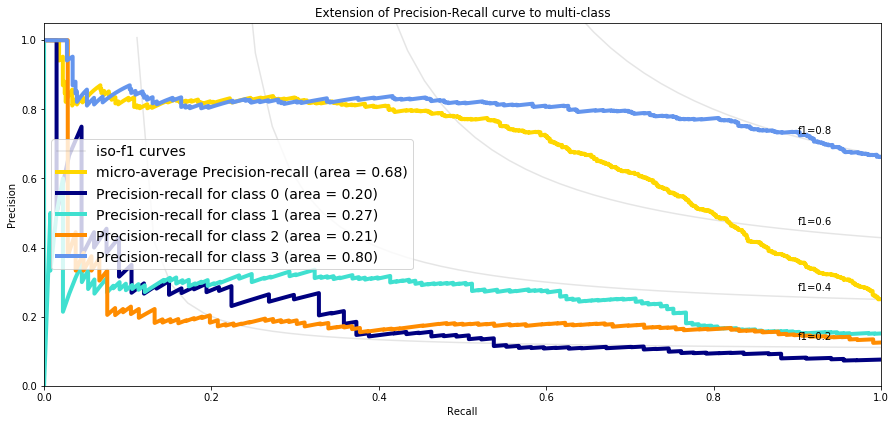

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.419158
Code block 'overalltime' took(HH:MM:SS): 0:03:36.459000
216459.0004738843


In [116]:
response = execute(x_train_lda,
        _y_train,
        x_test_lda,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [117]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.605566,0.344554,0.662556,1343.39,0,0,0.324835,189.735
logisticregression,0.606791,0.35699,0.650224,11474.6,0.73682,0.85688,0.674133,106.126
randomforestclassifier,0.622599,0.380334,0.643498,3572.05,0.693378,0.835225,3.67502,339.22
kneighborsclassifier,0.619413,0.396651,0.643498,10489.4,0.704902,0.840619,4.98347,171.883
decisiontreeclassifier,0.595844,0.357352,0.609865,2439.71,0.668973,0.787228,1.03083,235.053
perceptron,0.585202,0.342726,0.571749,1821.73,0,0,0.376035,113.66
svc,0.0688476,0.144912,0.131166,177142,0.678586,0.841918,15.6052,4900.26


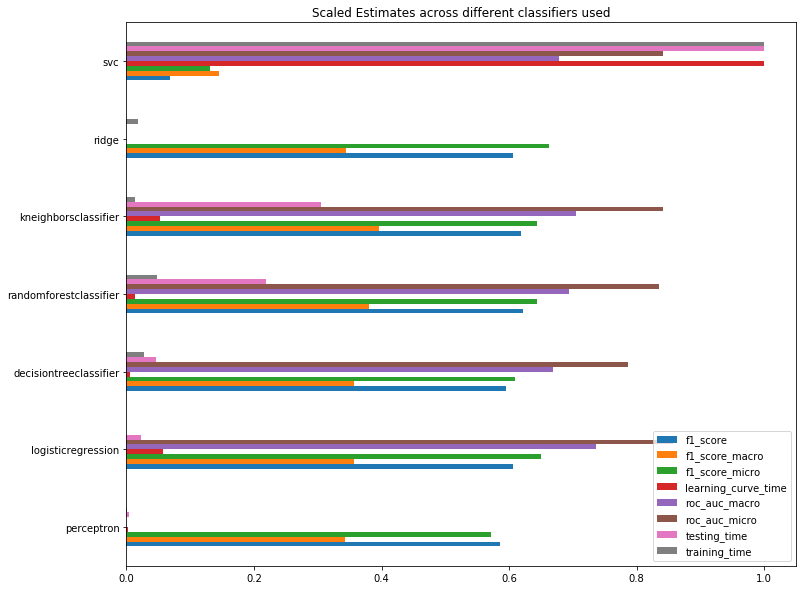

In [118]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion:  Pretty Similar scores as  LDA techniques